In [1]:

import pandas as pd 
import numpy as np
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_validate, KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from statsmodels.tools.tools import add_constant
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
import warnings 
from sklearn.linear_model import ElasticNetCV
import joblib
warnings.filterwarnings('ignore')

In [112]:
df = pd.read_csv('/kaggle/input/vehicle-dataset-from-cardekho/car data.csv')
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [113]:
df.shape

(301, 9)

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [115]:
df.describe(include=['number'])

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [116]:
df.describe(include=['object'])

,Car_Name,Fuel_Type,Seller_Type,Transmission
count,301,301,301,301
unique,98,3,2,2
top,city,Petrol,Dealer,Manual
freq,26,239,195,261


In [117]:
df.isnull().values.any()

False

In [118]:
#high number of car names. better to drop:
#one-hot encoding would create 98 new binary features, potentially leading to a sparse dataset
#model might learn patterns specific to individual car names that don't generalize well
df.drop('Car_Name', axis=1, inplace=True)
df.head(2)

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0


In [119]:
#better to have an age column relative to max year with an intercept of 1, instead of year
#relative measure vs absolute measure
max_date = df['Year'].max()
df['cars_age'] = max_date - df['Year'] + 1
df.drop('Year', axis = 1, inplace=True)
df.head(2)

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,cars_age
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,5
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,6


# Outlier Handling

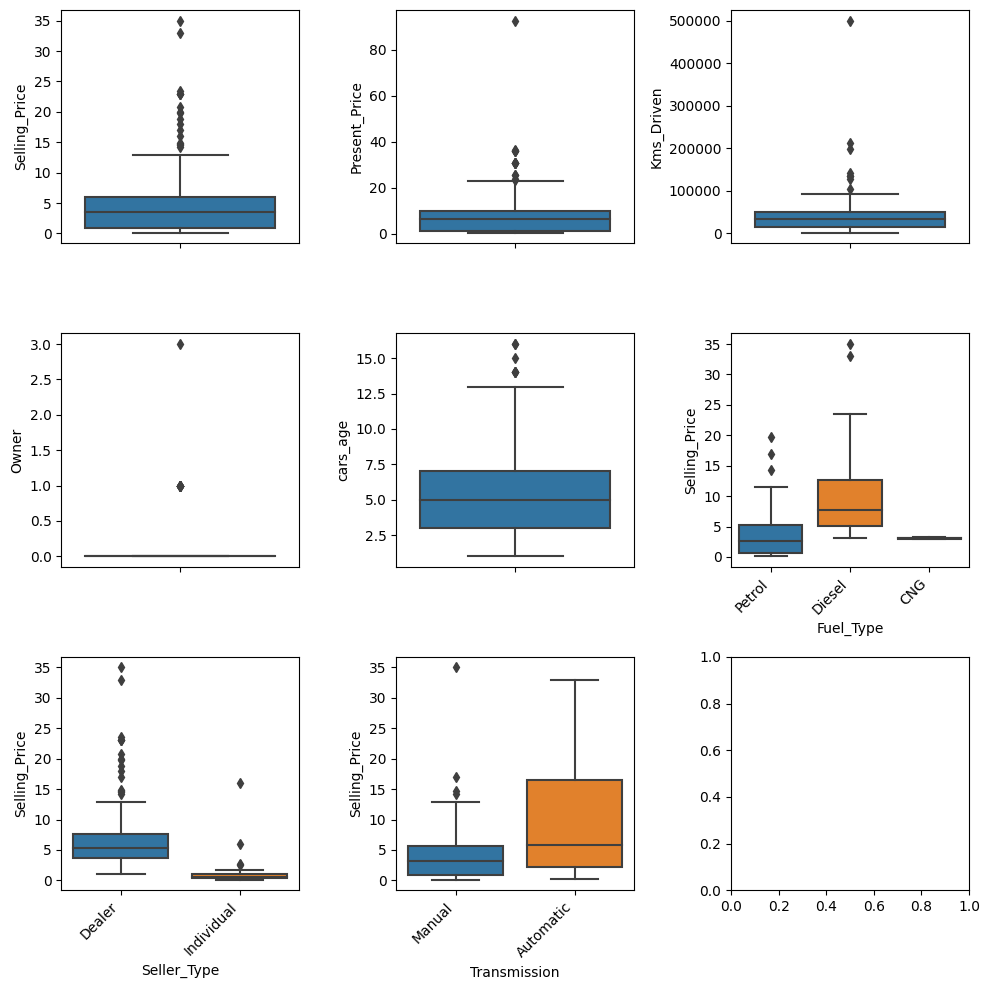

In [120]:
#boxplot outliers
#plot objects boxplots relative to price
numeric_columns = df.select_dtypes(include=['number']).columns
object_columns = df.select_dtypes(include=['object']).columns
all_columns = list(numeric_columns) + list(object_columns)

n_cols = 3
n_rows = (len(all_columns) - 1) // n_cols + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))

axes = axes.flatten()

for i, column in enumerate(all_columns):
    if df[column].dtype in ['int64', 'float64', 'float32']:
        sns.boxplot(data=df, y=column, ax=axes[i])
    else:
        numeric_col = numeric_columns[0]  #plot relative to selling_price
        sns.boxplot(data=df, x=column, y=numeric_col, ax=axes[i])
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [121]:
#Use the IQR rule to find outliers 
#1. find median, 
#2. find first (Q1) and third quartiles (Q3), 
#3. IQR = Q3 - Q1 
#4. fence = 1.5(IQR)
#5. Q1 - fence gives lower fence for outliers less than lower fence 
#6. Q3 + fence gives higher fence for outliers greater than higher fence 

#for object columns, for each category within the column, we need to use selling price as 
#a metric to measure the relative selling price based on the category 
#e.g.flag outliers for prices for diesel (diesel is a category in fuel_type col)

outlier_indices = []
target = 'Selling_Price'

numeric_columns = df.select_dtypes(include=['number']).columns
categorical_columns = df.select_dtypes(include=['object']).columns
 
for col in numeric_columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)

    iqr = (q3 - q1)
    minimum = q1 - (1.5 * iqr)
    maximum = q3 + (1.5 * iqr)

    outlier_samples = df[(df[col] < minimum) | (df[col] > maximum)]
    outlier_indices.extend(outlier_samples.index.to_list())

for col in categorical_columns:
    for cat in df[col].unique():
        df1 = df[df[col] == cat]
        q1 = df1[target].quantile(0.25)
        q3 = df1[target].quantile(0.75)
        iqr = (q3 - q1)
        minimum = q1 - (1.5 * iqr)
        maximum = q3 + (1.5 * iqr)
        outlier_samples = df1[(df1[target] < minimum) | (df1[target] > maximum)]
        outlier_indices.extend(outlier_samples.index.to_list())
    

outlier_indices = list((set(outlier_indices)))
numeric_columns, categorical_columns, len(outlier_indices)

(Index(['Selling_Price', 'Present_Price', 'Kms_Driven', 'Owner', 'cars_age'], dtype='object'),
 Index(['Fuel_Type', 'Seller_Type', 'Transmission'], dtype='object'),
 38)

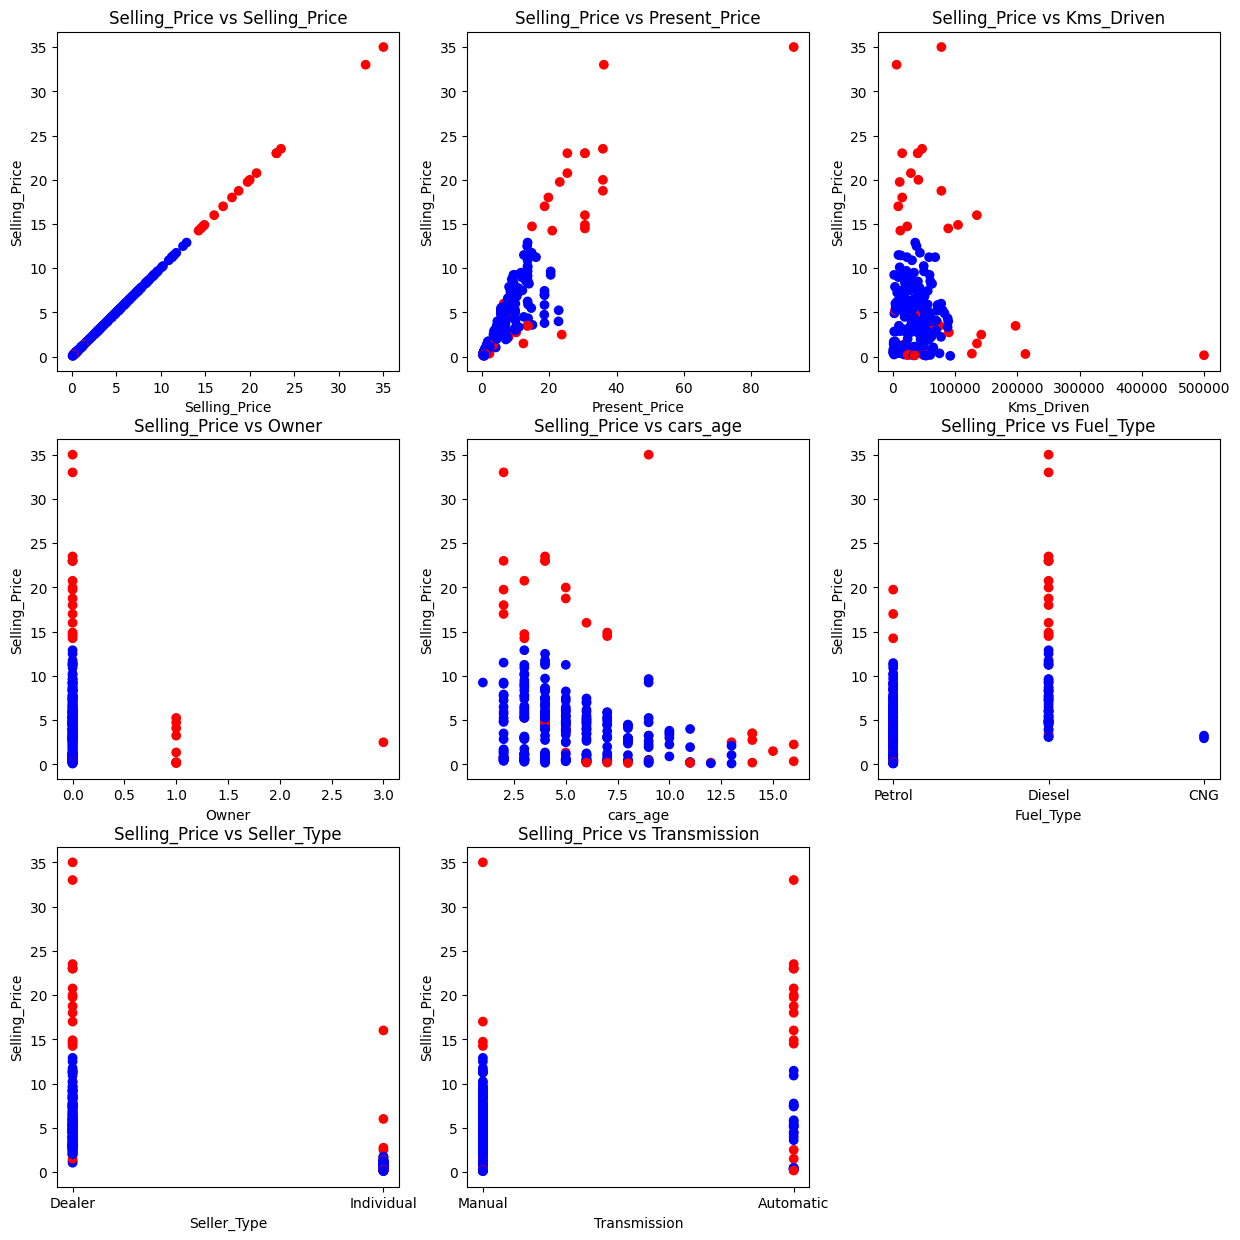

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [122]:
#plot outliers
df_plot = df.copy()
df_plot['Outlier'] = 'No'
df_plot.loc[outlier_indices, 'Outlier'] = 'Yes'

n_numeric_cols = len(numeric_columns)
n_categorical_cols = len(categorical_columns)
n_total_cols = n_numeric_cols + n_categorical_cols

n_cols = 3
n_rows = (n_total_cols + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    ax = axes[i]
    plt.figure(figsize=(5, 5))
    ax.scatter(df_plot[col], df_plot[target], c=df_plot['Outlier'].apply(lambda x: 'red' if x == 'Yes' else 'blue'), label='Outlier')
    ax.set_xlabel(col)
    ax.set_ylabel(target)
    ax.set_title(f'{target} vs {col}')

for i, col in enumerate(categorical_columns):
    ax = axes[n_numeric_cols + i]
    plt.figure(figsize=(5, 5))
    for cat in df_plot[col].unique():
        subset = df_plot[df_plot[col] == cat]
        ax.scatter(subset[col], subset[target], label=f'{col} = {cat}', c=subset['Outlier'].apply(lambda x: 'red' if x == 'Yes' else 'blue'))
        [ax.axis('off') for ax in axes.flatten()[len(numeric_columns) + len(categorical_columns):]]
    ax.set_xlabel(col)
    ax.set_ylabel(target)
    ax.set_title(f'{target} vs {col}')
plt.tight_layout()
plt.show()

In [123]:
#Outlier Capping
df1 = df.copy()
df1 = df1[df1['Kms_Driven'] <= 400000]
df1 = df1[df1['Selling_Price'] <= 33]

df1['Selling_Price'].max(), df1['Kms_Driven'].max()

(33.0, 213000)

# **EDA**

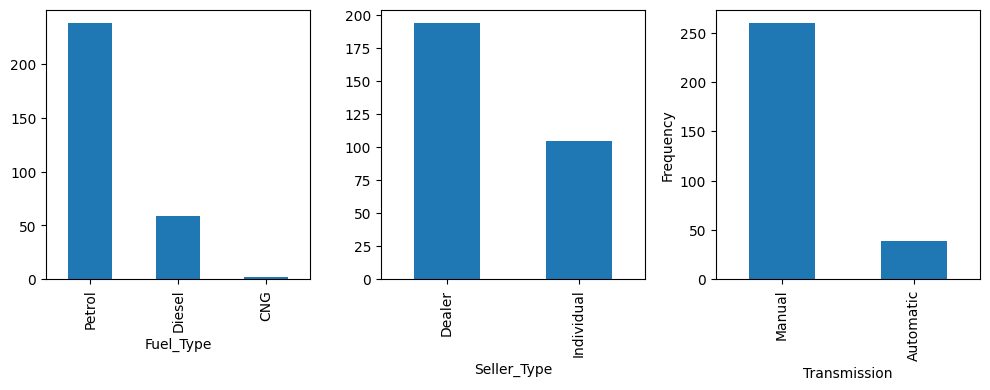

In [124]:
#Categorical Variables Univariate Analysis - examining the frequency distribution of each category within a categorical column
cat_columns = df1.select_dtypes(include=['object']).columns
cat_columns.to_list()

n_cols = 3
n_rows = (len(cat_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4))

for i, column in enumerate(cat_columns):
    df1[column].value_counts().plot(kind='bar', ax=axes[i])
    plt.xlabel(column)
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

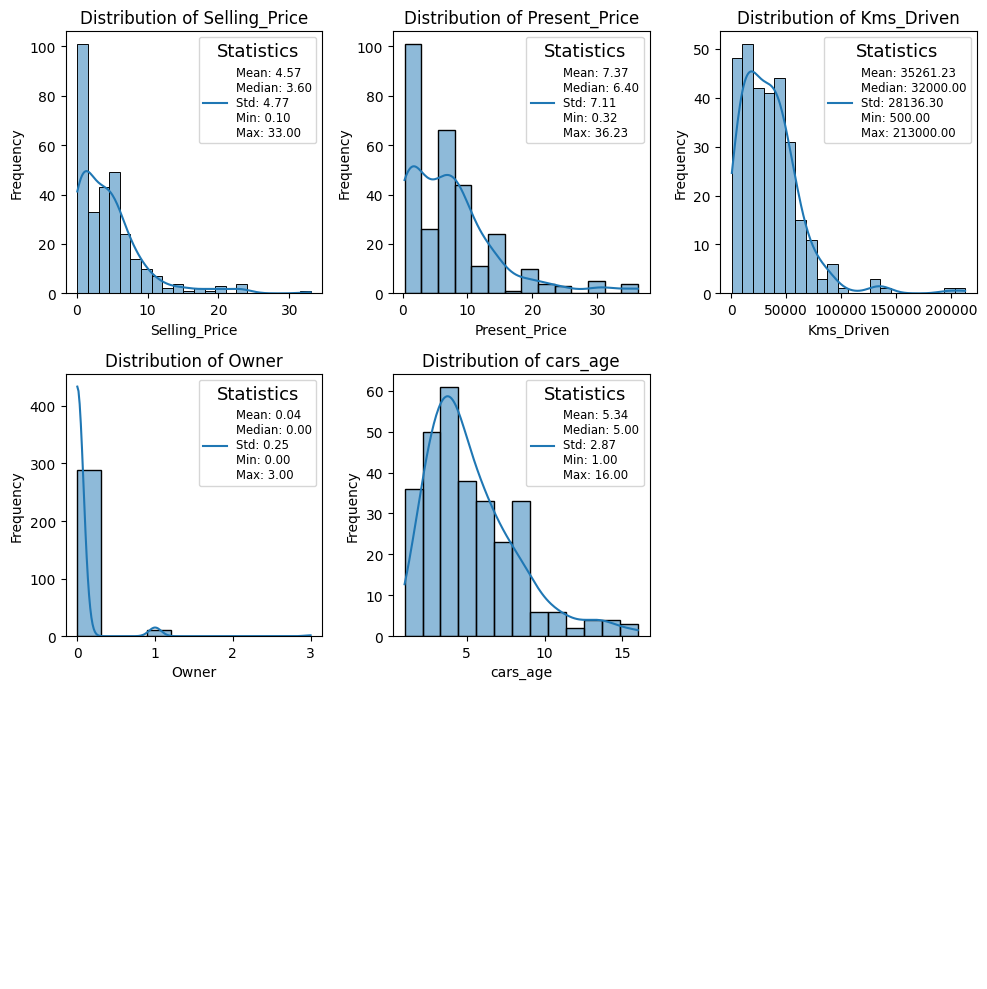

In [125]:
#Numerical Variables Univariate Analysis - understand underlying patterns for each variable within the dataset 
#mean, median, min val, max val, std
numerical_columns = df1.select_dtypes(include = ['number']).columns.to_list()

fix, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.histplot(df1[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    min_value = df1[col].min()
    max_value = df1[col].max()
    mean_value = np.mean(df1[col])
    std_value = np.std(df1[col])
    median_value = np.median(df1[col])
    
    legend_text = (f'Mean: {mean_value:.2f}\n'
                   f'Median: {median_value:.2f}\n'
                   f'Std: {std_value:.2f}\n'
                   f'Min: {min_value:.2f}\n'
                   f'Max: {max_value:.2f}')
    axes[i].legend([legend_text], loc='upper right', fontsize='small', title='Statistics', title_fontsize='13')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')
    
plt.tight_layout()
plt.show()

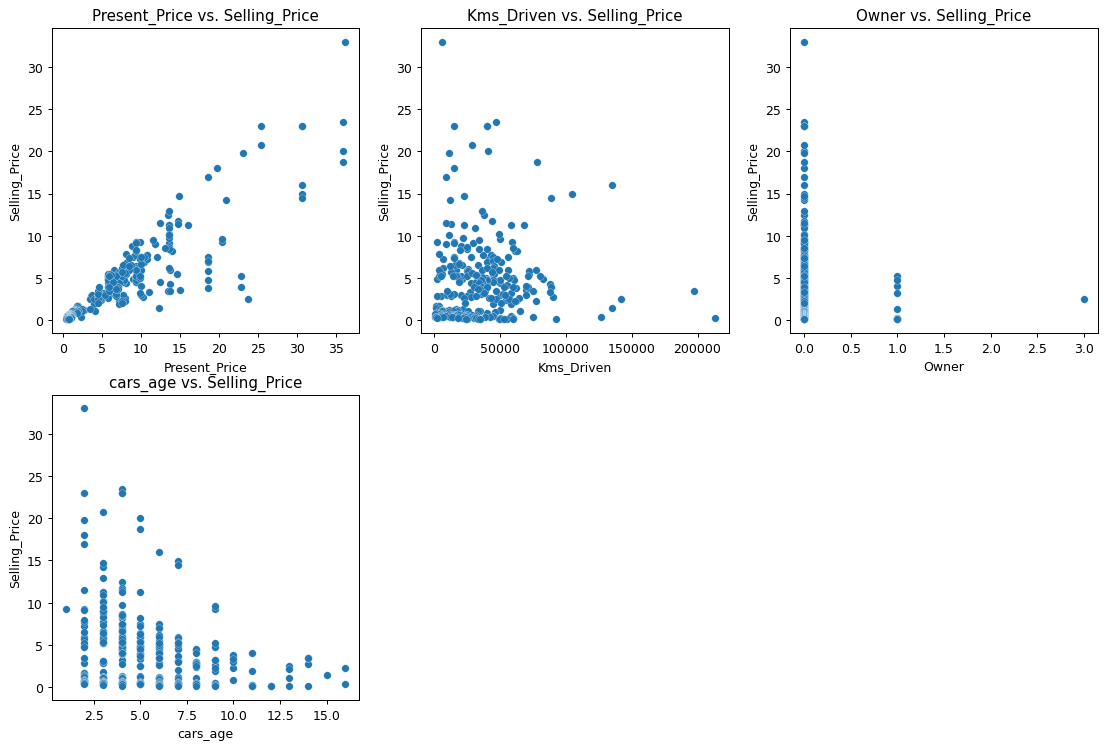

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [126]:
#Target vs. Numerical Features Bivariate Analysis - Compare Indepdent variable relationship to dependent variable
target = 'Selling_Price'
numerical_cols = df1.select_dtypes(include=['number']).columns
numerical_cols = [col for col in numerical_cols if col != target]  # Exclude target column

fig, axes = plt.subplots(3, 3, figsize=(15, 15), dpi=90)
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.scatterplot(x=df1[col], y=df1[target], ax=axes[i], linewidth=0.2)
    plt.figure(figsize=(5, 5))
    axes[i].set_title(f'{col} vs. {target}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(target)

for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
#present price goes up with selling price
#More KMS Driven, lower price 
#Price of Car decreases as age increases

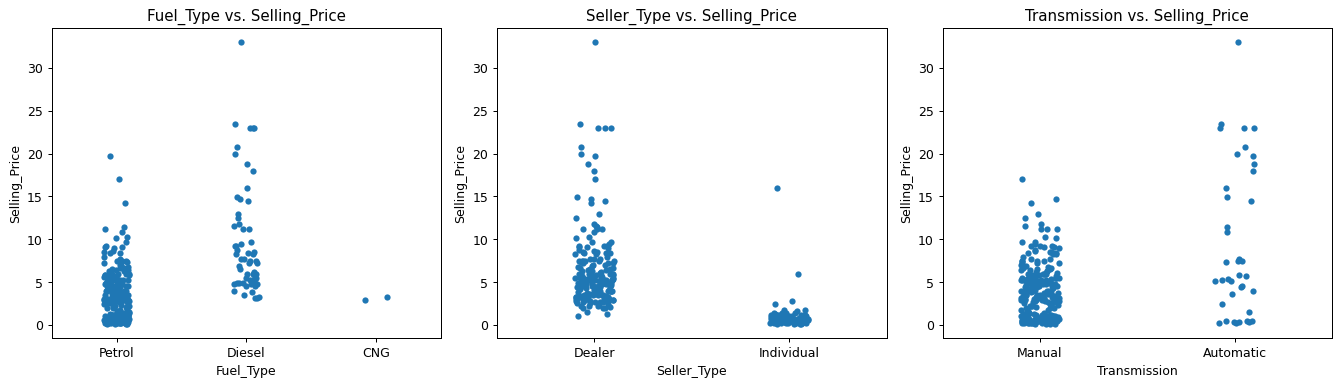

In [127]:
#Target vs. Categorical Features Bivariate Analysis
target = 'Selling_Price'
cat_cols = df1.select_dtypes(include=['object']).columns
cat_cols = [col for col in cat_cols if col != target]

fig, axes = plt.subplots(2, 3, figsize=(15, 8), dpi=90)
axes = axes.flatten()
for i, col in enumerate(cat_cols):
    sns.stripplot(x=df1[col], y=df1[target], ax=axes[i])
    axes[i].set_title(f'{col} vs. {target}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(target)
    
    
for j in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

#Diesel cars are more expensive than Petrol cars
#Selling prices of cars sold by dealers is higher than individuals
#Automatic cars are more expensive than manual

In [128]:
#Multivariate Analysis

In [129]:
# One Hot Encoding
cat_cols = df1.select_dtypes(include=['object'])

one_hot = OneHotEncoder(sparse=False,handle_unknown='ignore')
encoded = one_hot.fit_transform(cat_cols)

encoded_df = pd.DataFrame(encoded, columns=one_hot.get_feature_names_out(cat_cols.columns))
df1 = df1.drop(columns=cat_cols.columns)
df1 = pd.concat([df1, encoded_df], axis=1)
df1 = df1.drop(columns=['Fuel_Type_CNG', 'Seller_Type_Dealer', 'Transmission_Automatic'])
df1.head(3)

# df1 = pd.get_dummies(df1, columns=Cat_Cols, drop_first=True) #can use get_dummies instead to automatically handle dummy var for multicollinearity
# df1.head(5)

,Selling_Price,Present_Price,Kms_Driven,Owner,cars_age,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,3.35,5.59,27000.0,0.0,5.0,0.0,1.0,0.0,1.0
1,4.75,9.54,43000.0,0.0,6.0,1.0,0.0,0.0,1.0
2,7.25,9.85,6900.0,0.0,2.0,0.0,1.0,0.0,1.0


In [130]:
#Corr Matrix
corr_matrix = df1.corr()
target_corr = corr_matrix['Selling_Price'].sort_values(ascending=False)
target_corr

Selling_Price             1.000000
Present_Price             0.883903
Fuel_Type_Diesel          0.387573
Kms_Driven                0.062810
Owner                    -0.091101
cars_age                 -0.275162
Fuel_Type_Petrol         -0.377715
Transmission_Manual      -0.379616
Seller_Type_Individual   -0.549707
Name: Selling_Price, dtype: float64

<Axes: >

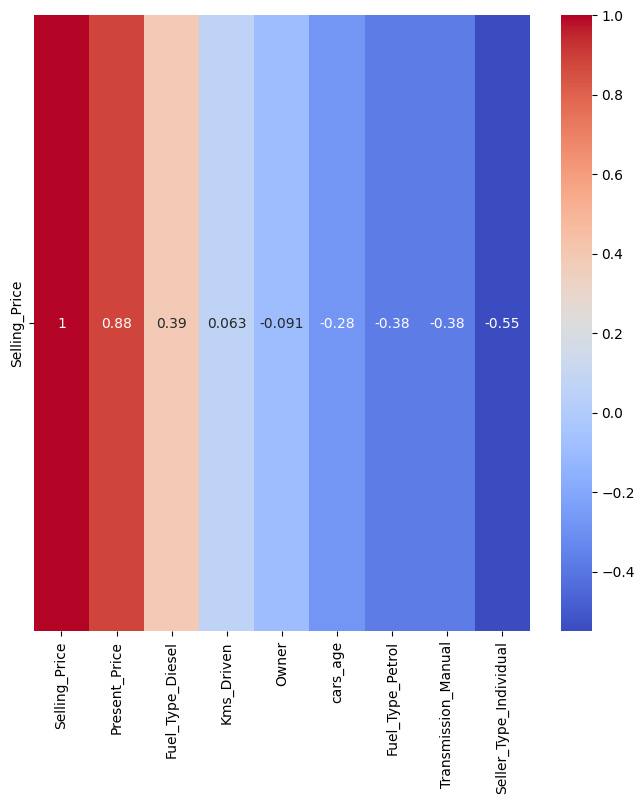

In [131]:
plt.figure(figsize=(8, 8))
sns.heatmap(target_corr.to_frame().transpose(), annot=True, cmap='coolwarm')

# Model Building

In [132]:
df1 = df1.dropna(subset=['Selling_Price']) #drop null values for price

In [133]:
X = df1.drop('Selling_Price', axis = 1)
y = df1['Selling_Price']

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [135]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(209, 8) (209,) (90, 8) (90,)


In [136]:
y_test_actual = y_test

In [137]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.fit_transform(X_test), columns=X_test.columns)

In [138]:
#must only use data from train set for scaling
scaler = StandardScaler()
scaler.fit(X_train_imputed)
X_train_scaled = scaler.transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [139]:
regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train)

LinearRegression()

In [140]:
regressor.coef_, regressor.intercept_

(array([ 4.19854792, -0.74535225, -0.32529183, -0.70751759,  0.34917669,
         0.3259951 , -0.23308887,  0.11188857]),
 4.37622009569378)

In [141]:
def evaluate_predictions(X_test_scaled, y_test):
    y_pred = regressor.predict(X_test_scaled)
    
    MSE = np.mean(np.square(y_test - y_pred))
    MAE = np.mean(np.abs(y_test - y_pred))
    RMSE = np.sqrt(MSE)
    R2_score = r2_score(y_test, y_pred)
    
    return MSE, MAE, RMSE, R2_score

MSE, MAE, RMSE, R2_score = evaluate_predictions(X_test_scaled, y_test)
print(f'MSE: {MSE}, MAE: {MAE}, RMSE:{RMSE}, R2:{R2_score}')

MSE: 4.594326225771332, MAE: 1.4173124746086165, RMSE:2.143437945397844, R2:0.8392629516799031


# Cross Validation and Learning Curves

In [142]:
#K fold cross validation
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())

])

def rmse(y_pred, y_test):
    return np.sqrt((mean_squared_error(y_test, y_pred)))

scoring = {
    'MSE': make_scorer(mean_squared_error), 
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(rmse), 
    'R2': make_scorer(r2_score)
}

kf = KFold(n_splits=5, shuffle=True, random_state=None)
cv_results = cross_validate(pipeline, X, y, cv=kf, scoring=scoring)
# for k, v in cv_results.items(): print(k, v)

mse, mae, rmse, r2 = cv_results['test_MSE'], cv_results['test_MAE'], cv_results['test_RMSE'], cv_results['test_R2']
print(f'MSE: {np.mean(mse)}, MAE: {np.mean(mae)}, RMSE:{np.mean(rmse)}, R2:{np.mean(r2)}')

MSE: 3.436646842431254, MAE: 1.1746038156752374, RMSE:1.8403800194047513, R2:0.8293582433816903


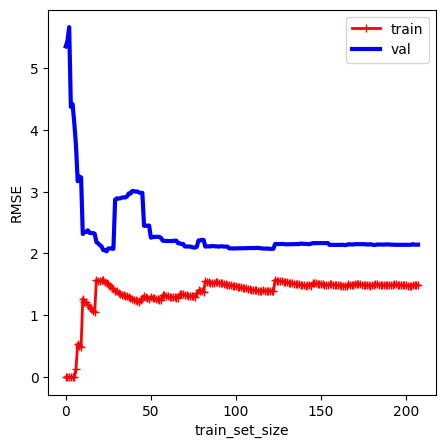

In [143]:
def plot_learning_curve(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
    train_errors, val_errors = [], []
    
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')), 
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ])
    for i in range(1, len(X_train)):
        pipeline.fit(X_train[:i], y_train[:i])
        y_train_predict = pipeline.predict(X_train[:i])
        y_val_predict = pipeline.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:i], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.figure(figsize=(5, 5))
    plt.xlabel('train_set_size')
    plt.ylabel('RMSE')
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='train')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='val')
    plt.legend()
    plt.show()
plot_learning_curve(X, y)

#error on training data starts low but as training instances are added, error goes up and plateaus
#validation error is large due to small number of instances (incapable of generalizing properly) - as it learns though, error goes down but is plateauing.
#underfitting, as data is not linear

# Linear Regression Assumptions

In [144]:
#compute residuals to reuse the function
def residuals(model, X_test_scaled, y_test):
    y_pred = regressor.predict(X_test_scaled)
    df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    return df_results

### Assumption 1: Linear Relationship. Test using a regression line plot.

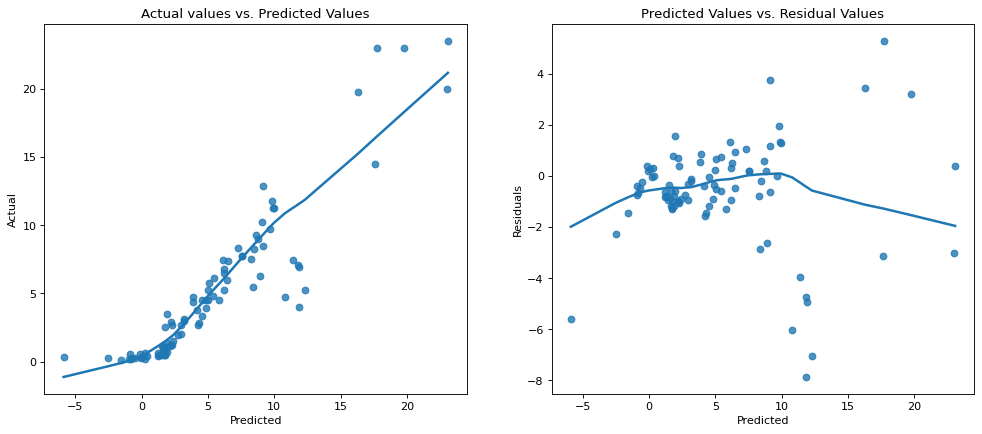

In [145]:
def compute_linearity(model, X_test_scaled, y_test):
    
    df_results = residuals(model, X_test_scaled, y_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 6), dpi=80)
    sns.regplot(x='Predicted', y='Actual', lowess=True, data=df_results, ax = ax[0])
    ax[0].set_title('Actual values vs. Predicted Values')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')
    
    sns.regplot(x='Predicted', y='Residuals', lowess=True, data=df_results, ax=ax[1])
    ax[1].set_title('Predicted Values vs. Residual Values')
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Residuals')
compute_linearity(regressor, X_test_scaled, y_test)
#non linear line - introduce polynomial features or nonlinear transforms

### Assumption 2: Normality of Residuals - Shapiro - Wilk test

Shapiro-Wilk Test Statistic: 0.8822
Shapiro-Wilk Test P-Value: 0.0000007046


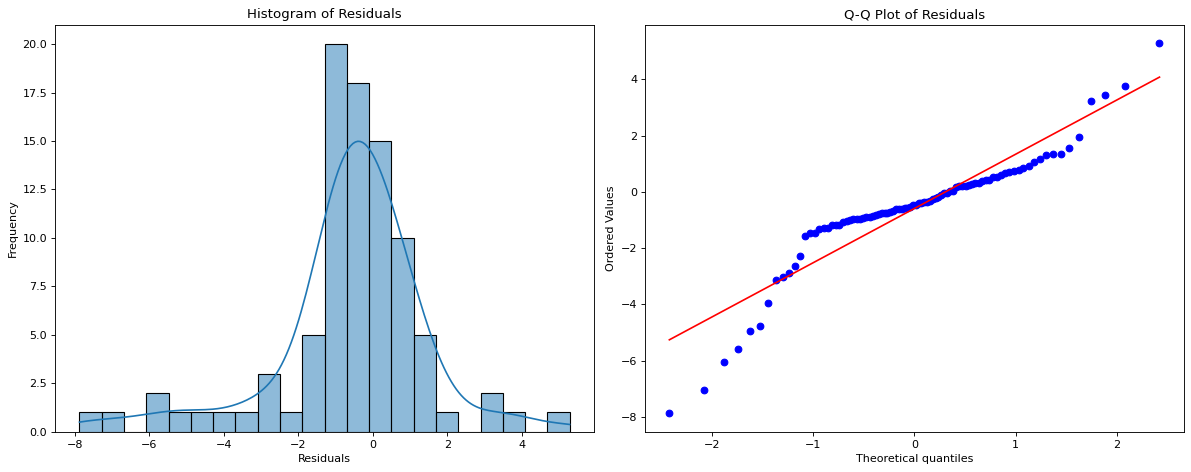

In [146]:
def plot_normality(model, X_test_scaled, y_test):
    df_residuals = residuals(model, X_test_scaled, y_test)
    residuals_data = df_residuals['Residuals']
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 6), dpi=80)
    shapiro_stat, shapiro_p_value = stats.shapiro(residuals_data)
    
    print(f'Shapiro-Wilk Test Statistic: {shapiro_stat:.4f}')
    print(f'Shapiro-Wilk Test P-Value: {shapiro_p_value:.10f}')
    
    sns.histplot(residuals_data, kde=True, ax=ax[0])
    ax[0].set_title('Histogram of Residuals')
    ax[0].set_xlabel('Residuals')
    ax[0].set_ylabel('Frequency')
    
    stats.probplot(residuals_data, dist='norm', plot=ax[1])
    ax[1].set_title('Q-Q Plot of Residuals')
    
    plt.tight_layout()
    plt.show()
plot_normality(regressor, X_test_scaled, y_test)
#data is skewed - residuals are not normally distributed
#not following guassian distribution 
#statistic value of 0.822 is closer to 1 - data is more normally distributed 
#p value < 0.05, so data deviates from a normal distribution. reject the null

### Assumption 3: No Multicollinearity - test using VIF  

In [147]:
#Multicollinearity test - VIF 
vif_data = pd.DataFrame()
vif_data['feature'] = X_train_imputed.columns
vif_data['vif'] = [variance_inflation_factor(X_train_imputed.values, i) for i in range(len(X_train_imputed.columns))]
vif_data = vif_data.sort_values(by='vif', ascending=True)
vif_data['vif'] = vif_data['vif'].round(2)

print(vif_data)

                  feature    vif
2                   Owner   1.16
6  Seller_Type_Individual   2.40
0           Present_Price   4.22
4        Fuel_Type_Diesel   5.28
1              Kms_Driven   6.56
3                cars_age   8.37
7     Transmission_Manual  10.37
5        Fuel_Type_Petrol  16.49


### Assumption 4: Independence of Residuals (Autocorrelation). Test using Durbin Watson 

In [148]:
def compute_autocorrelation(model, X_test_scaled, y_test):
    df_residuals = residuals(model, X_test_scaled, y_test)
    residuals_data = df_residuals['Residuals']
    
    autocorrelation_score = durbin_watson(residuals_data, axis=0)
    if autocorrelation_score < 1.5:
        print(f'score: {autocorrelation_score}, positive autocorrelation')
    elif autocorrelation_score > 2.5:
        print(f'score: {autocorrelation_score}, negative autocorrelation')
    elif 1.5 < autocorrelation_score < 2.5:
        print(f'score: {autocorrelation_score}, little to no significant autocorrelation')
    else:
        raise ValueError()
    
compute_autocorrelation(regressor, X_test_scaled, y_test)
#assumption satisfied

score: 2.0413504256778303, little to no significant autocorrelation


### Assumption 5: Homoscedasticity - Bresuch-Pagan Test

LM Stat: 33.672191161850435
LM Stat P-Value: 4.657497582897818e-05
F stat: 7.002680843299785
F stat P-Value: 1.5397713240093868e-06


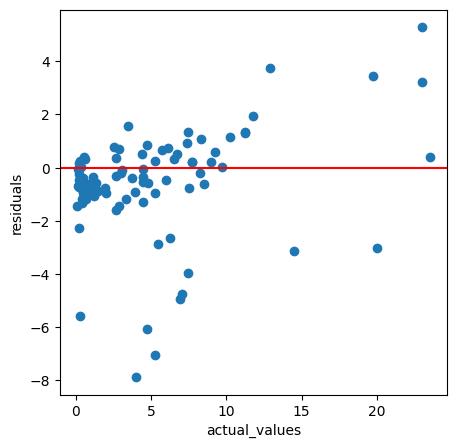

In [149]:
def test_homoscedasticity(model, X_test_scaled, y_test):
    df_residuals = residuals(model, X_test_scaled, y_test)
    residuals_data = df_residuals['Residuals']
    actual_data = df_residuals['Actual']
    
    exog_het = add_constant(X_test_scaled)
    ht_test = het_breuschpagan(residuals_data, exog_het, robust=True)
    print(f'LM Stat: {ht_test[0]}')
    print(f'LM Stat P-Value: {ht_test[1]}')
    print(f'F stat: {ht_test[2]}')
    print(f'F stat P-Value: {ht_test[3]}')
    
    
    plt.figure(figsize=(5, 5))
    plt.scatter(actual_data, residuals_data, c=None)
    plt.axhline(y=0, color='r')
    plt.xlabel('actual_values')
    plt.ylabel('residuals')
    

test_homoscedasticity(regressor, X_test_scaled, y_test)
#both p values < 0.05, suggesting that heteroscedasticity is present in the dataset. Assumption
#of homoscedasticity not met

# Box Cox and Polynomial Features with Degree 2

In [150]:
fitted_lambda = pd.Series(np.zeros(len(df1.columns), dtype=np.float64), index=df1.columns)

In [151]:
y_train, fitted_lambda['Selling_Price'] = stats.boxcox(y_train + 1)
for col in X_train_imputed.columns:
    X_train_imputed[col], fitted_lambda[col] = stats.boxcox(X_train_imputed[col]+1)

fitted_lambda

Selling_Price             -0.039555
Present_Price              0.078569
Kms_Driven                 0.404374
Owner                    -33.502585
cars_age                  -0.342207
Fuel_Type_Diesel          -6.893038
Fuel_Type_Petrol           6.585170
Seller_Type_Individual    -2.554365
Transmission_Manual       13.400877
dtype: float64

In [152]:
y_test = stats.boxcox(y_test + 1, fitted_lambda['Selling_Price'])
for col in X_test_imputed.columns:
    X_test_imputed[col] = stats.boxcox(X_test_imputed[col] + 1, fitted_lambda[col])

In [153]:
y_train = pd.DataFrame(y_train, index=X_train_imputed.index,columns=['Selling_Price'])
y_test = pd.DataFrame(y_test, index=X_test_imputed.index, columns=['Selling_Price'])

X_boxcox = pd.concat([X_train_imputed, X_test_imputed])
y_boxcox = pd.concat([y_train, y_test])

df_boxcox = pd.concat([X_boxcox, y_boxcox], axis=1)
del df_boxcox['Fuel_Type_Petrol']

In [154]:
X, y = df_boxcox.drop('Selling_Price', axis=1), df_boxcox['Selling_Price']

In [155]:
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X, y, test_size=0.3, random_state=42) 

In [156]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])
pipeline.fit(X_poly_train, y_poly_train)

Pipeline(steps=[('imputer', SimpleImputer()),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [157]:
def evaluate_predictions(X_poly_test, y_poly_test): 
    y_pred = pipeline.predict(X_poly_test)
    MSE = np.mean(np.square(y_poly_test - y_pred)) 
    
    MAE = np.mean(np.abs(y_poly_test - y_pred)) 
    RMSE = np.sqrt(MSE) 
    R2_score = r2_score(y_poly_test, y_pred)
    return MSE, MAE, RMSE, R2_score 

MSE, MAE, RMSE, R2_score = evaluate_predictions(X_poly_test, y_poly_test) 
print(MSE, MAE, RMSE, R2_score)

0.014024700384352802 0.09264066955075315 0.11842592783826016 0.9775164295464939


In [158]:
#K fold cross validation
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())

])

def rmse(y_pred, y_test):
    return np.sqrt((mean_squared_error(y_test, y_pred)))

scoring = {
    'MSE': make_scorer(mean_squared_error), 
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(rmse), 
    'R2': make_scorer(r2_score)
}

kf = KFold(n_splits=5, shuffle=True, random_state=None)
cv_results = cross_validate(pipeline, X, y, cv=kf, scoring=scoring)
mse, mae, rmse, r2 = cv_results['test_MSE'], cv_results['test_MAE'], cv_results['test_RMSE'], cv_results['test_R2']
print(f'MSE: {np.mean(mse)}, MAE: {np.mean(mae)}, RMSE:{np.mean(rmse)}, R2:{np.mean(r2)}')

MSE: 24.26425899349122, MAE: 0.500631027691004, RMSE:2.3095028254649685, R2:-46.826194792489986


### Test Assumptions for Poly Features 

In [159]:
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X, y, test_size=0.3, random_state=42) 

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])
pipeline.fit(X_poly_train, y_poly_train)

Pipeline(steps=[('imputer', SimpleImputer()),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [160]:
#compute residuals to reuse the function
def df_residuals(pipeline, X_poly_test, y_poly_test):
    y_pred = pipeline.predict(X_poly_test)
    df_results = pd.DataFrame({'Actual': y_poly_test, 'Predicted': y_pred})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    return df_results

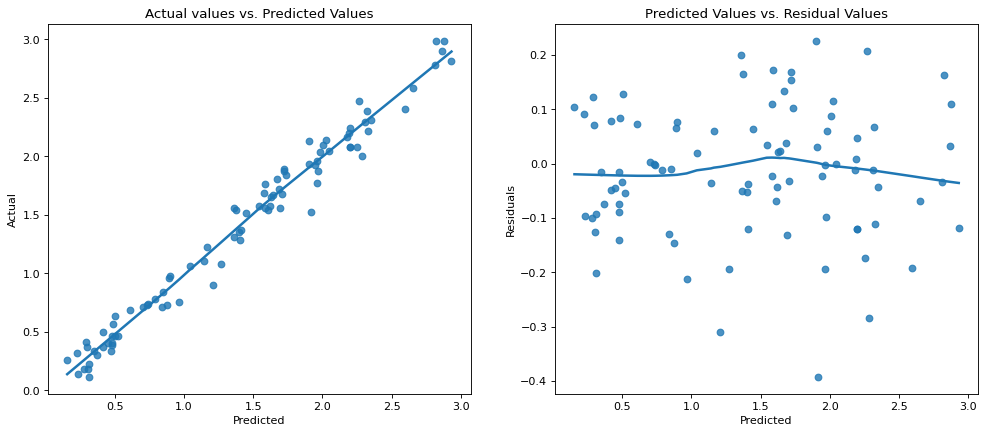

In [161]:
#Regression Line Plot
def compute_linearity():
    df_results = df_residuals(pipeline, X_poly_test, y_poly_test)
    fig, ax = plt.subplots(1, 2, figsize=(15, 6), dpi=80)
    sns.regplot(x='Predicted', y='Actual', lowess=True, data=df_results, ax = ax[0])
    ax[0].set_title('Actual values vs. Predicted Values')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')
    
    sns.regplot(x='Predicted', y='Residuals', lowess=True, data=df_results, ax=ax[1])
    ax[1].set_title('Predicted Values vs. Residual Values')
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Residuals')
compute_linearity()

Shapiro-Wilk Test Statistic: 0.9845
Shapiro-Wilk Test P-Value: 0.3605484752


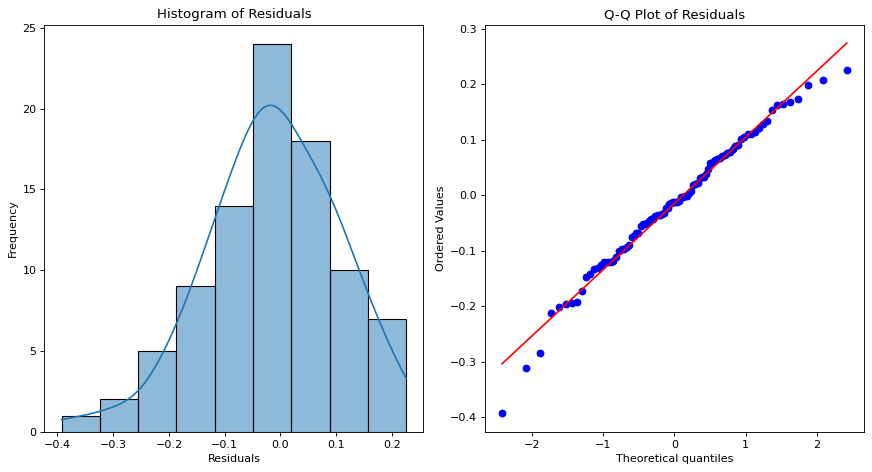

In [162]:
#Normality of Residuals
def plot_normality():
    df_results = df_residuals(pipeline, X_poly_test, y_poly_test)
    residuals_data = df_results['Residuals']
    fig, ax = plt.subplots(1, 2, figsize=(11, 6), dpi=80)
    shapiro_stat, shapiro_p_value = stats.shapiro(residuals_data)
    
    print(f'Shapiro-Wilk Test Statistic: {shapiro_stat:.4f}')
    print(f'Shapiro-Wilk Test P-Value: {shapiro_p_value:.10f}')
    
    sns.histplot(residuals_data, kde=True, ax=ax[0])
    ax[0].set_title('Histogram of Residuals')
    ax[0].set_xlabel('Residuals')
    ax[0].set_ylabel('Frequency')
    
    stats.probplot(residuals_data, dist='norm', plot=ax[1])
    ax[1].set_title('Q-Q Plot of Residuals')
    
    plt.tight_layout()
    plt.show()
plot_normality()
#data is skewed - residuals are not normally distributed
#not following guassian distribution 
#statistic value of 0.9845 is closer to 1 - data is more normally distributed than previous linear reg model
#p value > 0.05, so data is more normally distributed. Residuals have improved to follow a more guassian distribution.

In [163]:
#Multicollinearity Test - VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X_poly_train.columns
vif_data['vif'] = [variance_inflation_factor(X_poly_train.values, i) for i in range(len(X_poly_train.columns))]
vif_data = vif_data.sort_values(by='vif', ascending=True)
vif_data['vif'] = vif_data['vif'].round(2)

print(vif_data)

#VIF is producing higher numbers with the addition of poly features 
#Regularization could improve this. 

                  feature    vif
2                   Owner   1.10
4        Fuel_Type_Diesel   1.58
5  Seller_Type_Individual   3.15
6     Transmission_Manual   6.42
0           Present_Price   9.94
1              Kms_Driven  19.24
3                cars_age  35.34


In [164]:
#Autocorrelation of residuals
def compute_autocorrelation():
    df_residuals_data = df_residuals(pipeline, X_poly_test, y_poly_test)
    residuals_data = df_residuals_data['Residuals']
    
    autocorrelation_score = durbin_watson(residuals_data, axis=0)
    if autocorrelation_score < 1.5:
        print(f'score: {autocorrelation_score}, positive autocorrelation')
    elif autocorrelation_score > 2.5:
        print(f'score: {autocorrelation_score}, negative autocorrelation')
    elif 1.5 < autocorrelation_score < 2.5:
        print(f'score: {autocorrelation_score}, little to no significant autocorrelation')
    else:
        raise ValueError()
    
compute_autocorrelation()
#assumption satisfied - autocorrelation has not increased nor decreased.

score: 2.029924624057256, little to no significant autocorrelation


LM Stat: 4.520424075843357
LM Stat P-Value: 0.807386280772558
F stat: 0.6194876214775445
F stat P-Value: 0.7383654849489416


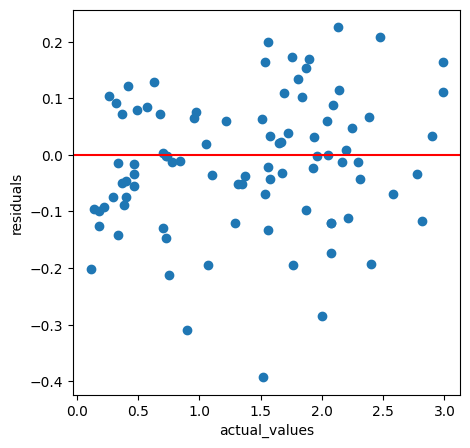

In [165]:
#Homoscedascity
def test_homoscedasticity():
    df_residuals_data = df_residuals(pipeline, X_poly_test, y_poly_test)
    residuals_data = df_residuals_data['Residuals']
    actual_data = df_residuals_data['Actual']
    exog_het = add_constant(X_test_scaled)
    ht_test = het_breuschpagan(residuals_data, exog_het, robust=True)
    print(f'LM Stat: {ht_test[0]}')
    print(f'LM Stat P-Value: {ht_test[1]}')
    print(f'F stat: {ht_test[2]}')
    print(f'F stat P-Value: {ht_test[3]}')
    
    
    plt.figure(figsize=(5, 5))
    plt.scatter(actual_data, residuals_data, c=None)
    plt.axhline(y=0, color='r')
    plt.xlabel('actual_values')
    plt.ylabel('residuals')
    

test_homoscedasticity()
#both p values > 0.05, suggesting that the homoscedasticity assumption is satisfied.

# Regularization 

### There is still one assumption not met within the model - high multicollinearity. We can test different regularization methods to improve this.

### Ridge Regression  

#### 1. Compute Residuals: Calculate the difference between actual and predicted values.
#### 2. Define Cost Function: Combine squared residuals with a penalty term proportional to the sum of the squared coefficients (regularized term).
#### 3. Set Regularization Hyperparameter alpha (α): Choose α to control the strength of the penalty. 
#### 4. Minimize Cost Function: Adjust coefficients to minimize the cost function, shrinking them toward zero to reduce overfitting.

### cost function = squared residuals + α * sum of squared coefs

In [166]:
X, y = df_boxcox.drop('Selling_Price', axis=1), df_boxcox['Selling_Price']

In [167]:
X_ridge_train, X_ridge_test, y_ridge_train, y_ridge_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [168]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', RidgeCV(alphas=[0.01, 0.1, 1, 10, 100]))
])
pipeline.fit(X_ridge_train, y_ridge_train)

Pipeline(steps=[('imputer', SimpleImputer()),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('regressor', RidgeCV(alphas=[0.01, 0.1, 1, 10, 100]))])

In [169]:
best_alpha = pipeline.named_steps['regressor'].alpha_ #access best hyperparameters
best_alpha

0.1

In [170]:
def evaluate_predictions(X_ridge_test, y_ridge_test): 
    y_pred = pipeline.predict(X_ridge_test)
    MSE = np.mean(np.square(y_ridge_test - y_pred)) 
    
    MAE = np.mean(np.abs(y_ridge_test - y_pred)) 
    RMSE = np.sqrt(MSE) 
    R2_score = r2_score(y_ridge_test, y_pred)
    return MSE, MAE, RMSE, R2_score 

MSE, MAE, RMSE, R2_score = evaluate_predictions(X_ridge_test, y_ridge_test) 
print(MSE, MAE, RMSE, R2_score)

0.014087210445182206 0.09193050274589783 0.11868955491188854 0.9774162171128451


In [171]:
ridge_cv = pipeline.named_steps['regressor']
coefs = ridge_cv.coef_
coefs

array([ 0.94914991,  0.10529093,  0.00907217,  0.37844737, -0.02512821,
       -0.07731211, -0.0191582 ,  0.0251651 ,  0.10551188, -0.08531106,
       -0.55723725,  0.07326552,  0.08961779,  0.08839596,  0.07708298,
        0.00738379, -0.32116807, -0.0140251 ,  0.06401899, -0.06281945,
        0.00907217,  0.08860845,  0.        , -0.05841789, -0.00656093,
       -0.30867951,  0.06225651, -0.09190163,  0.10384804, -0.08674464,
       -0.01497845,  0.02381473, -0.13643292,  0.09519662, -0.11067171])

#### Lasso Regression

#### Cost Function=Sum of Squared Residuals + α * Sum of Absolute Coefficients

In [172]:
X, y = df_boxcox.drop('Selling_Price', axis=1), df_boxcox['Selling_Price']

In [173]:
X_lasso_train, X_lasso_test, y_lasso_train, y_lasso_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [174]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', LassoCV(alphas=[0.01, 0.1, 1, 10, 100]))
])
pipeline.fit(X_lasso_train, y_lasso_train)

Pipeline(steps=[('imputer', SimpleImputer()),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('regressor', LassoCV(alphas=[0.01, 0.1, 1, 10, 100]))])

In [175]:
best_alpha = pipeline.named_steps['regressor'].alpha_ #access best hyperparameters
best_alpha

0.01

In [176]:
def evaluate_predictions(X_lasso_test, y_lasso_test): 
    y_pred = pipeline.predict(X_lasso_test)
    MSE = np.mean(np.square(y_lasso_test - y_pred)) 
    
    MAE = np.mean(np.abs(y_lasso_test - y_pred)) 
    RMSE = np.sqrt(MSE) 
    R2_score = r2_score(y_lasso_test, y_pred)
    return MSE, MAE, RMSE, R2_score 

MSE, MAE, RMSE, R2_score = evaluate_predictions(X_lasso_test, y_lasso_test) 
print(MSE, MAE, RMSE, R2_score)

0.026000750137877757 0.12111449805868756 0.16124748102800787 0.9583171346589903


In [177]:
lasso_cv = pipeline.named_steps['regressor']
coefs = lasso_cv.coef_
coefs

array([ 0.63737485, -0.        ,  0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.01749178,
       -0.        ,  0.01949278, -0.        ,  0.00186662, -0.        ,
       -0.        , -0.07442718,  0.        ,  0.        ,  0.00364508,
        0.        ,  0.        ,  0.        , -0.        ,  0.00738457,
       -0.12206798,  0.        , -0.        ,  0.        ,  0.        ,
        0.01188398,  0.        , -0.07653016, -0.        ,  0.        ])

#### Elastic Net Regression

#### Cost Function = Sum of Squared Residuals + α(ρ × Sum of Absolute Coefficients + (1-ρ)/2 × Sum of Squared Coefficients)
#### where p is the mixing parameter between Lasso and Ridge regularization

In [178]:
X, y = df_boxcox.drop('Selling_Price', axis=1), df_boxcox['Selling_Price']

In [179]:
X_elastic_train, X_elastic_test, y_elastic_train, y_elastic_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [180]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', ElasticNetCV(alphas=[0.01, 0.1, 1, 10, 100]))
])
pipeline.fit(X_elastic_train, y_elastic_train)

Pipeline(steps=[('imputer', SimpleImputer()),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('regressor', ElasticNetCV(alphas=[0.01, 0.1, 1, 10, 100]))])

In [181]:
best_alpha = pipeline.named_steps['regressor'].alpha_ #access best hyperparameters
best_alpha

0.01

In [182]:
def evaluate_predictions(X_elastic_test, y_elastic_test): 
    y_pred = pipeline.predict(X_elastic_test)
    MSE = np.mean(np.square(y_elastic_test - y_pred)) 
    
    MAE = np.mean(np.abs(y_elastic_test - y_pred)) 
    RMSE = np.sqrt(MSE) 
    R2_score = r2_score(y_elastic_test, y_pred)
    return MSE, MAE, RMSE, R2_score 

MSE, MAE, RMSE, R2_score = evaluate_predictions(X_elastic_test, y_elastic_test) 
print(MSE, MAE, RMSE, R2_score)

0.024831424993158855 0.11817790152065721 0.1575799003463286 0.9601917275952984


In [183]:
elastic_cv = pipeline.named_steps['regressor']
coefs  = elastic_cv.coef_
coefs

array([ 0.60977484,  0.        ,  0.00156854, -0.        ,  0.        ,
       -0.05404795, -0.        ,  0.02598751, -0.        , -0.02461682,
       -0.        ,  0.02491048,  0.        ,  0.        , -0.        ,
       -0.        , -0.11060865,  0.        ,  0.02666557,  0.01893095,
        0.00083462,  0.        ,  0.        , -0.00262963,  0.01532659,
       -0.10773597,  0.        ,  0.        ,  0.        ,  0.        ,
        0.01869526,  0.        , -0.05886455, -0.        , -0.        ])

# Test different degrees of polynomial features 

In [184]:
X, y = df_boxcox.drop('Selling_Price', axis=1), df_boxcox['Selling_Price']

def poly_degree_test(X, y, max_degree=5):
    MAE_vals, MSE_vals, RMSE_vals, R2_Score_vals = [], [], [], []

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for i in range(1, max_degree + 2):
        pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')), 
            ('poly', PolynomialFeatures(degree=i)), 
            ('scaler', StandardScaler()), 
            ('regressor', ElasticNetCV(alphas=[0.01, 0.1, 1, 10, 100]))
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        MSE = mean_squared_error(y_test, y_pred)
        MAE = mean_absolute_error(y_test, y_pred)
        RMSE = np.sqrt(MSE)
        R2_score = r2_score(y_test, y_pred)

        MSE_vals.append((i, MSE))
        MAE_vals.append((i, MAE))
        RMSE_vals.append((i, RMSE))
        R2_Score_vals.append((i, R2_score))
    
    return MSE_vals, MAE_vals, RMSE_vals, R2_Score_vals

MSE_vals, MAE_vals, RMSE_vals, R2_Score_vals = poly_degree_test(X, y)

print(f'MSE_vals: {MSE_vals}')
print(f'MAE_vals: {MAE_vals}')
print(f'RMSE_vals: {RMSE_vals}')
print(f'R2_score_vals: {R2_Score_vals}')

#degree of 6 is producing the best results

MSE_vals: [(1, 0.029105148217315815), (2, 0.024831424993158855), (3, 0.01805132190030622), (4, 0.01542990499921232), (5, 0.014356287432768301), (6, 0.014076871507652132)]
MAE_vals: [(1, 0.12595663943541993), (2, 0.11817790152065721), (3, 0.10139154744977447), (4, 0.09641230208310796), (5, 0.09337591623892803), (6, 0.0921837393168366)]
RMSE_vals: [(1, 0.17060231011717225), (2, 0.1575799003463286), (3, 0.13435520793890432), (4, 0.12421716869745632), (5, 0.11981772587045833), (6, 0.11864599237922928)]
R2_score_vals: [(1, 0.9533403472038624), (2, 0.9601917275952984), (3, 0.9710611880038974), (4, 0.9752636885899002), (5, 0.9769848487953758), (6, 0.9774327918862094)]


# Best Model Test and Assumptions (6th Degree Polynomial + Elastic Net)

In [185]:
X, y = df_boxcox.drop('Selling_Price', axis=1), df_boxcox['Selling_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), 
    ('poly', PolynomialFeatures(degree=6)), 
    ('scaler', StandardScaler()), 
    ('regressor', ElasticNetCV(alphas=[0.01, 0.1, 1, 10, 100]))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()),
                ('poly', PolynomialFeatures(degree=6)),
                ('scaler', StandardScaler()),
                ('regressor', ElasticNetCV(alphas=[0.01, 0.1, 1, 10, 100]))])

In [186]:
def evaluate_predictions(X_test, y_test): 
    y_pred = pipeline.predict(X_test)
    MSE = np.mean(np.square(y_test - y_pred)) 
    
    MAE = np.mean(np.abs(y_test - y_pred)) 
    RMSE = np.sqrt(MSE) 
    R2_score = r2_score(y_test, y_pred)
    return MSE, MAE, RMSE, R2_score 

MSE, MAE, RMSE, R2_score = evaluate_predictions(X_test, y_test) 
print(MSE, MAE, RMSE, R2_score)

0.014076871507652132 0.0921837393168366 0.11864599237922928 0.9774327918862094


### Test Assumptions

In [187]:
#compute residuals to reuse the function
def df_residuals(pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test)
    df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    return df_results

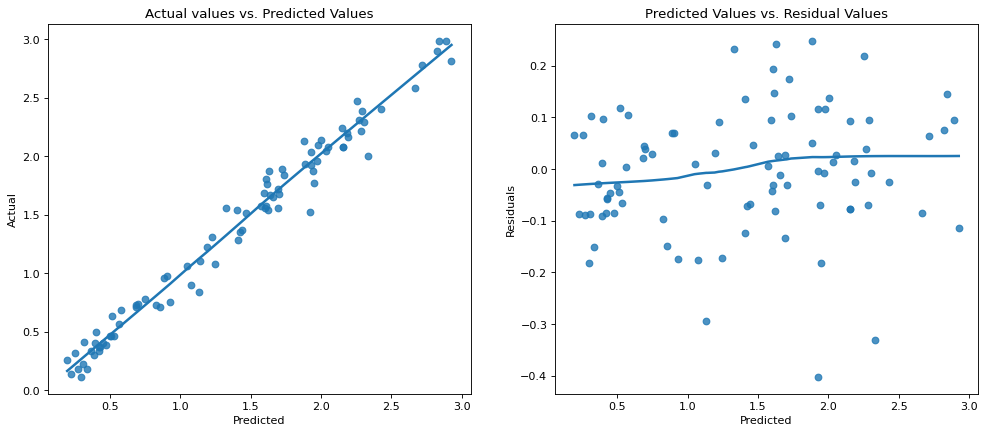

In [188]:
#Regression Line Plot
def compute_linearity():
    df_results = df_residuals(pipeline, X_test, y_test)
    fig, ax = plt.subplots(1, 2, figsize=(15, 6), dpi=80)
    sns.regplot(x='Predicted', y='Actual', lowess=True, data=df_results, ax = ax[0])
    ax[0].set_title('Actual values vs. Predicted Values')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')
    
    sns.regplot(x='Predicted', y='Residuals', lowess=True, data=df_results, ax=ax[1])
    ax[1].set_title('Predicted Values vs. Residual Values')
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Residuals')
compute_linearity()

Shapiro-Wilk Test Statistic: 0.9765
Shapiro-Wilk Test P-Value: 0.1027823178


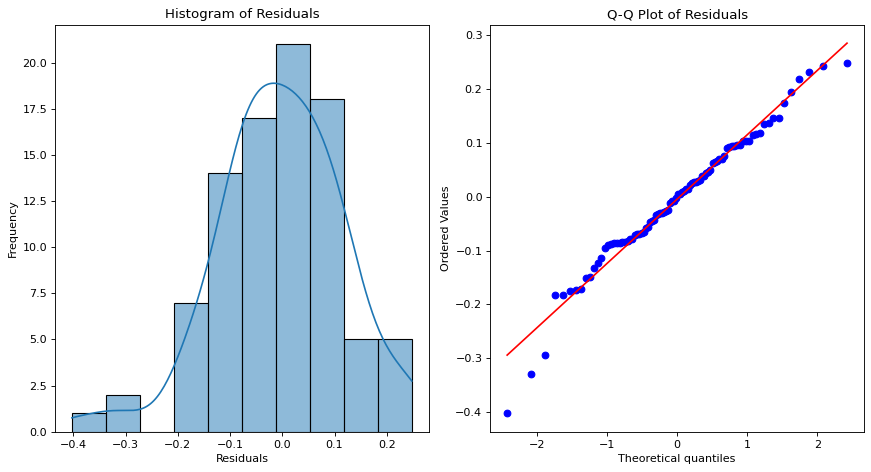

In [189]:
#Normality of Residuals
def plot_normality():
    df_results = df_residuals(pipeline, X_test, y_test)
    residuals_data = df_results['Residuals']
    fig, ax = plt.subplots(1, 2, figsize=(11, 6), dpi=80)
    shapiro_stat, shapiro_p_value = stats.shapiro(residuals_data)
    
    print(f'Shapiro-Wilk Test Statistic: {shapiro_stat:.4f}')
    print(f'Shapiro-Wilk Test P-Value: {shapiro_p_value:.10f}')
    
    sns.histplot(residuals_data, kde=True, ax=ax[0])
    ax[0].set_title('Histogram of Residuals')
    ax[0].set_xlabel('Residuals')
    ax[0].set_ylabel('Frequency')
    
    stats.probplot(residuals_data, dist='norm', plot=ax[1])
    ax[1].set_title('Q-Q Plot of Residuals')
    
    plt.tight_layout()
    plt.show()
plot_normality()
#data is skewed - residuals are not normally distributed
#not following guassian distribution 
#statistic value of 0.9765 is closer to 1 - data is normally distributed 
#p value > 0.05, so data is normally distributed.

In [190]:
#Autocorrelation of residuals
def compute_autocorrelation():
    df_residuals_data = df_residuals(pipeline, X_test, y_test)
    residuals_data = df_residuals_data['Residuals']
    
    autocorrelation_score = durbin_watson(residuals_data, axis=0)
    if autocorrelation_score < 1.5:
        print(f'score: {autocorrelation_score}, positive autocorrelation')
    elif autocorrelation_score > 2.5:
        print(f'score: {autocorrelation_score}, negative autocorrelation')
    elif 1.5 < autocorrelation_score < 2.5:
        print(f'score: {autocorrelation_score}, little to no significant autocorrelation')
    else:
        raise ValueError()
    
compute_autocorrelation()
#assumption satisfied - autocorrelation has not increased nor decreased.

score: 2.0783913645668646, little to no significant autocorrelation


In [191]:
#Multicollinearity Test - VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X_train.columns
vif_data['vif'] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
vif_data = vif_data.sort_values(by='vif', ascending=True)
vif_data['vif'] = vif_data['vif'].round(2)
print(vif_data)
#VIF is still high

                  feature    vif
2                   Owner   1.10
4        Fuel_Type_Diesel   1.58
5  Seller_Type_Individual   3.15
6     Transmission_Manual   6.42
0           Present_Price   9.94
1              Kms_Driven  19.24
3                cars_age  35.34


In [2]:
# #Homoscedascity
# def test_homoscedasticity():
#     df_residuals_data = df_residuals(pipeline, X_test, y_test)
#     residuals_data = df_residuals_data['Residuals']
#     actual_data = df_residuals_data['Actual']
#     exog_het = add_constant(X_test)
#     ht_test = het_breuschpagan(residuals_data, exog_het, robust=True)
#     print(f'LM Stat: {ht_test[0]}')
#     print(f'LM Stat P-Value: {ht_test[1]}')
#     print(f'F stat: {ht_test[2]}')
#     print(f'F stat P-Value: {ht_test[3]}')
    
    
#     plt.figure(figsize=(5, 5))
#     plt.scatter(actual_data, residuals_data, c=None)
#     plt.axhline(y=0, color='r')
#     plt.xlabel('actual_values')
#     plt.ylabel('residuals')
    

# test_homoscedasticity()

#### Removal of features with high muilticollinearity 

In [193]:
X, y = df_boxcox.drop('Selling_Price', axis=1), df_boxcox['Selling_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


def remove_features(X, threshold=15):
    X = X.copy()
    
    while True:
        vif_data = pd.DataFrame()
        vif_data['feature'] = X.columns
        vif_data['vif'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
        vif_data = vif_data.sort_values(by='vif', ascending=True)
        vif_data['vif'] = vif_data['vif'].round(2)

        max_vif = vif_data['vif'].max()

        if max_vif > threshold:
            feature_to_drop = vif_data[vif_data['vif'] == max_vif]['feature'].values[0]
            print(f'Dropping feature: {feature_to_drop}')
            X = X.drop(columns=[feature_to_drop])
        else:
            break 

    return X 
X_train_removed = remove_features(X_train)

Dropping feature: cars_age


In [194]:
X_test_removed = X_test[X_train_removed.columns]

In [205]:
alphas = np.logspace(-4, 4, 50)
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), 
    ('poly', PolynomialFeatures(degree=6)), 
    ('scaler', StandardScaler()), 
    ('regressor', ElasticNetCV(alphas=[0.01, 0.1, 1, 10, 100]))
])

pipeline.fit(X_train_removed, y_train)

Pipeline(steps=[('imputer', SimpleImputer()),
                ('poly', PolynomialFeatures(degree=6)),
                ('scaler', StandardScaler()),
                ('regressor', ElasticNetCV(alphas=[0.01, 0.1, 1, 10, 100]))])

In [206]:
def evaluate_predictions(X_test_removed, y_test): 
    y_pred = pipeline.predict(X_test_removed)
    MSE = np.mean(np.square(y_test - y_pred)) 
    
    MAE = np.mean(np.abs(y_test - y_pred)) 
    RMSE = np.sqrt(MSE) 
    R2_score = r2_score(y_test, y_pred)
    return MSE, MAE, RMSE, R2_score 

MSE, MAE, RMSE, R2_score = evaluate_predictions(X_test_removed, y_test) 
print(MSE, MAE, RMSE, R2_score)

0.03937991894220901 0.15021409316335543 0.19844374251210092 0.9368684422678755


# Random Forest and GBR Test  

In [237]:
X = df1.drop('Selling_Price', axis=1)
y = df1['Selling_Price']

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [239]:
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler()), 
    ('model', RandomForestRegressor(max_features=8, n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)

def evaluate_predictions(X_test, y_test): 
    y_pred = pipeline.predict(X_test)
    MSE = np.mean(np.square(y_test - y_pred)) 
    
    MAE = np.mean(np.abs(y_test - y_pred)) 
    RMSE = np.sqrt(MSE) 
    R2_score = r2_score(y_test, y_pred)
    return MSE, MAE, RMSE, R2_score 

MSE, MAE, RMSE, R2_score = evaluate_predictions(X_test, y_test) 
print(MSE, MAE, RMSE, R2_score)

1.0416764837777794 0.6353688888888894 1.020625535530921 0.9635559176517146


In [240]:
from sklearn.ensemble import GradientBoostingRegressor

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler()), 
    ('model', GradientBoostingRegressor(max_features=8, n_estimators=50, random_state=42))
])

pipeline.fit(X_train, y_train)

def evaluate_predictions(X_test, y_test): 
    y_pred = pipeline.predict(X_test)
    MSE = np.mean(np.square(y_test - y_pred)) 
    
    MAE = np.mean(np.abs(y_test - y_pred)) 
    RMSE = np.sqrt(MSE) 
    R2_score = r2_score(y_test, y_pred)
    return MSE, MAE, RMSE, R2_score 

MSE, MAE, RMSE, R2_score = evaluate_predictions(X_test, y_test) 
print(MSE, MAE, RMSE, R2_score)

0.9056556258730336 0.5856218348541409 0.9516594064438356 0.9683147419352265
